In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/omdena_ad

/content/drive/MyDrive/omdena_ad


In [ ]:
!pip install keras_tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 2.6 MB/s eta 0:00:00


In [ ]:
! pip install scikit-multilearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 1.9 MB/s eta 0:00:00


In [ ]:
import os
from distutils.dir_util import copy_tree, remove_tree
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import random
import os
from scipy.ndimage import rotate
import tensorflow
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, Input, BatchNormalization, Dropout
from keras import backend as K
from keras.applications import ResNet50, VGG16
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.decomposition import PCA
from keras.utils import to_categorical
import sklearn
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import kerastuner as kt
from kerastuner.tuners import RandomSearch, BayesianOptimization
from imblearn.over_sampling import SMOTE
from skmultilearn.model_selection import IterativeStratification
#from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import KFold

<ipython-input-5-8f01efec281f>:27: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


In [ ]:
!pip install kaggle


In [ ]:
from google.colab import files

uploaded = files.upload()


Saving kaggle.json to kaggle.json


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d tourist55/alzheimers-dataset-4-class-of-images

100% 34.0M/34.1M [00:01<00:00, 39.8MB/s]
100% 34.1M/34.1M [00:01<00:00, 25.1MB/s]


In [ ]:
! mkdir omdena_kaggle
!ls
!unzip alzheimers-dataset-4-class-of-images.zip -d omdena_kaggle

Streaming output truncated to the last 5000 lines.
  inflating: omdena_kaggle/Alzheimer_s Dataset/train/MildDemented/mildDem207.jpg  
  inflating: omdena_kaggle/Alzheimer_s Dataset/train/MildDemented/mildDem208.jpg  
  inflating: omdena_kaggle/Alzheimer_s Dataset/train/MildDemented/mildDem209.jpg  
  inflating: omdena_kaggle/Alzheimer_s Dataset/train/MildDemented/mildDem21.jpg  
  inflating: omdena_kaggle/Alzheimer_s Dataset/train/MildDemented/mildDem210.jpg  
  inflating: omdena_kaggle/Alzheimer_s Dataset/train/MildDemented/mildDem211.jpg  
  inflating: omdena_kaggle/Alzheimer_s Dataset/train/MildDemented/mildDem212.jpg  
  inflating: omdena_kaggle/Alzheimer_s Dataset/train/MildDemented/mildDem213.jpg  
  inflating: omdena_kaggle/Alzheimer_s Dataset/train/MildDemented/mildDem214.jpg  
  inflating: omdena_kaggle/Alzheimer_s Dataset/train/MildDemented/mildDem215.jpg  
  inflating: omdena_kaggle/Alzheimer_s Dataset/train/MildDemented/mildDem216.jpg  
  inflating: omdena_kaggle/Alzheimer_

In [ ]:
train_data_dir = "/content/drive/MyDrive/omdena_ad/omdena_kaggle/Alzheimer_s Dataset/train/"
test_data_dir = "/content/drive/MyDrive/omdena_ad/omdena_kaggle/Alzheimer_s Dataset/test/"
all_dataset_dir =  "/content/drive/MyDrive/omdena_ad/omdena_kaggle/Alzheimer_s Dataset/all_dataset"

In [ ]:
# combine train and test dataset to a single folder to split them later into train, test and val
# copy_tree(train_data_dir, all_dataset_dir)
# copy_tree(test_data_dir, all_dataset_dir)
# print(os.listdir(all_dataset_dir))

In [ ]:
data_class = sorted(os.listdir(train_data_dir))

In [ ]:
for dir in data_class:
    if dir == 'MildDemented':
      dir_path_mild_dem = os.path.join(train_data_dir, dir)
      mild_demented = os.listdir(dir_path_mild_dem)

    elif dir == 'ModerateDemented':
      dir_path_mod_dem = os.path.join(train_data_dir, dir)
      moderate_demented = os.listdir(dir_path_mod_dem)

    elif dir == 'NonDemented':
      dir_path_non_dem = os.path.join(train_data_dir, dir)
      non_demented = os.listdir(dir_path_non_dem)

    elif dir == 'VeryMildDemented':
      dir_path_v_m_dem = os.path.join(train_data_dir, dir)
      very_mild_demented = os.listdir(dir_path_v_m_dem)

In [ ]:
len(os.listdir(dir_path_mild_dem))

717

In [ ]:
 len(os.listdir(dir_path_mod_dem))

52

In [ ]:
len(os.listdir(dir_path_non_dem))

2560

In [ ]:
len(os.listdir(dir_path_v_m_dem))

1792

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255
    #validation_split=0.2
)
batch_size = 5121

# Create a flow generator for training data
train_generator = train_datagen.flow_from_directory(
    train_data_dir,             # Path to the training data directory
    target_size=(176, 176), # Target size of the images (height, width)
    batch_size=batch_size,  # Size of the batches
    class_mode='categorical' # Type of labels (binary or categorical)
    #subset = 'training'
)

Found 5121 images belonging to 4 classes.


In [ ]:
train_data, train_labels = train_generator.next()

In [ ]:
# train_data, test_data, train_labels, test_labels = sklearn.model_selection.train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

In [ ]:
# train_data, val_data, train_labels, val_labels = sklearn.model_selection.train_test_split(train_data, train_labels, test_size = 0.2, random_state=103)

In [ ]:
# image number for [mild, mod, non, very_mild] before SMOTE
train_image_num_before_smote = np.sum(train_labels, axis=0)
# test_image_num_before_smote = np.sum(test_labels, axis=0)
#val_image_num_before_smote = np.sum(val_labels, axis=0)
print(train_image_num_before_smote)#, test_image_num_before_smote, val_image_num_before_smote)


[ 717.   52. 2560. 1792.]


In [ ]:
print(train_data.shape, train_labels.shape)

(5121, 176, 176, 3) (5121, 4)


In [ ]:
#SMOTE to tackle class imbalance, but only to training data
sm = SMOTE(random_state=55)
train_data, train_labels = sm.fit_resample(train_data.reshape(-1, 176 * 176 * 3), train_labels)
train_data = train_data.reshape(-1, 176, 176, 3)
print(train_data.shape, train_labels.shape)

(10240, 176, 176, 3) (10240, 4)


In [ ]:
# image number for [mild, mod, non, very_mild] after SMOTE
train_image_num_after_smote = np.sum(train_labels, axis=0)
# test_image_num_after_smote = np.sum(test_labels, axis=0)
#val_image_num_after_smote = np.sum(val_labels, axis=0)
print(train_image_num_after_smote)#, test_image_num_after_smote, val_image_num_after_smote)


[2560 2560 2560 2560]


**KERAS TUNER TO BUILD A CUSTOM ARCHITECTURE**

In [ ]:
# Define the model builder function
def build_model(hp):
    model = keras.Sequential()

    # Choose the number of convolutional layers
    num_conv_layers = hp.Int('num_conv_layers', min_value=1, max_value=15, step=1)
    current_shape = (176, 176, 3)
    # Add convolutional layers
    for i in range(num_conv_layers):
        filters=hp.Int(f'conv_{i}_filters', min_value=16, max_value=128, step=16)
        kernel_size=hp.Choice(f'conv_{i}_kernel', values=[3,5])
        kernel_size = (kernel_size, kernel_size)
        model.add(tensorflow.keras.layers.Conv2D(
            filters=filters,
            kernel_size=kernel_size,
            activation='relu',
            padding='same',
            input_shape=current_shape
        ))

        # Check if the input size before MaxPooling2D is valid
        if current_shape[0] >= 2 and current_shape[1] >= 2:
            model.add(tensorflow.keras.layers.MaxPooling2D(pool_size=(2, 2)))
            current_shape = (current_shape[0] // 2, current_shape[1] // 2, current_shape[2])
        else:
            # Skip this combination
            print(f"Skipping combination due to invalid input size: {current_shape}, (2,2)")
            continue

        # BatchNormalization with tunable hyperparameter
        use_batchnorm = hp.Boolean(f'conv_{i}_use_batchnorm', default=True)
        if use_batchnorm:
            model.add(tensorflow.keras.layers.BatchNormalization())

        # Dropout with tunable hyperparameter
        dropout_rate = hp.Float(f'conv_{i}_dropout_rate', min_value=0.0, max_value=0.7, step=0.1)
        model.add(tensorflow.keras.layers.Dropout(rate=dropout_rate))

    model.add(tensorflow.keras.layers.Flatten())

    # Choose the number of dense layers
    num_dense_layers = hp.Int('num_dense_layers', min_value=1, max_value=5, step=1)

    # Add dense layers
    for i in range(num_dense_layers):
        model.add(tensorflow.keras.layers.Dense(
            units=hp.Int(f'dense_{i}_units', min_value=32, max_value=256, step=32),
            activation='relu'
        ))

        # BatchNormalization with tunable hyperparameter
        use_batchnorm_dense = hp.Boolean(f'dense_{i}_use_batchnorm', default=True)
        if use_batchnorm_dense:
            model.add(tensorflow.keras.layers.BatchNormalization())
        # Dropout with tunable hyperparameter
        dropout_rate_dense = hp.Float(f'dense_{i}_dropout_rate', min_value=0.0, max_value=0.7, step=0.1)
        model.add(tensorflow.keras.layers.Dropout(rate=dropout_rate_dense))
    # Output layer
    model.add(tensorflow.keras.layers.Dense(4, activation='softmax'))

    # Choose the learning rate
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
    # Choose the optimizer
    optimizer_choice = hp.Choice('optimizer', values=['adam', 'sgd', 'rmsprop'])
    if optimizer_choice == 'adam':
        optimizer = keras.optimizers.Adam(learning_rate)
    elif optimizer_choice == 'sgd':
        optimizer = keras.optimizers.SGD(learning_rate)
    elif optimizer_choice == 'rmsprop':
        optimizer = keras.optimizers.RMSprop(learning_rate)
    # Compile the model
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model


In [ ]:
class CVTuner(BayesianOptimization):
  def run_trial(self, trial, x, y, batch_size=16, epochs=10):
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    avg_val_accuracy = []
    s = 1
    for train_indices, test_indices in cv.split(x):
      print(f"This is split {s}")
      s = s+1
      x_train, x_test = x[train_indices], x[test_indices]
      y_train, y_test = y[train_indices], y[test_indices]
      model = self.hypermodel.build(trial.hyperparameters)
      model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=batch_size, epochs=epochs)
      result = model.evaluate(x_test, y_test)
      avg_val_accuracy.append(result[1])
    self.oracle.update_trial(trial.trial_id, {'val_accuracy': np.mean(avg_val_accuracy)})
    #self.save_model(trial.trial_id, model)

tuner = CVTuner(
    hypermodel=build_model,
    objective='val_accuracy',
    max_trials=10)

tuner.search(train_data, train_labels, batch_size=16, epochs=10)
#best_model = tuner.get_best_models(num_models=1)[0]

Trial 10 Complete [00h 03m 17s]
val_accuracy: 0.8437795400619507

Best val_accuracy So Far: 0.9445381045341492
Total elapsed time: 00h 34m 47s


NotFoundError: Unsuccessful TensorSliceReader constructor: Failed to find any matching files for ./untitled_project/trial_03/checkpoint

In [ ]:
#Use the best hyperparameters obtained to construct the model
def create_model():
    # Best hyperparameter values generated
    num_conv_layers = 7
    conv_0_filters = 32
    conv_0_kernel = 3
    conv_1_filters = 64
    conv_1_kernel = 5
    conv_2_filters = 32
    conv_2_kernel = 5
    conv_3_filters = 64
    conv_3_kernel = 5
    conv_4_filters = 128
    conv_4_kernel = 5
    conv_5_filters = 128
    conv_5_kernel = 5
    conv_6_filters = 128
    conv_6_kernel = 5
    num_dense_layers = 2
    dense_0_units = 64
    dense_1_units = 96
    learning_rate = 0.0015463
    #conv_1_filters = 128
    #conv_1_kernel = 5
    #conv_2_filters = 64
    #conv_2_kernel = 5
    # dense_2_units = 128
    # dense_3_units = 160
    # dense_4_units = 32
    #dense_2_units = 32

    # Define the model
    model = Sequential()

    # Add convolutional layers
    for i in range(num_conv_layers):
        model.add(Conv2D(
            filters=eval(f'conv_{i}_filters'),
            kernel_size=eval(f'conv_{i}_kernel'),
            activation='relu',
            padding='same',
            input_shape=(176, 176, 3)
        ))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        if i == 0:
          model.add(BatchNormalization())
          model.add(Dropout(0.1))  # Adding dropout for regularization
        if i == 1:
          model.add(BatchNormalization())
          model.add(Dropout(0.5))  # Adding dropout for regularization
        elif i == 2:
          model.add(BatchNormalization())
          model.add(Dropout(0.3))  # Adding dropout for regularization
        elif i == 3:
          model.add(BatchNormalization())
          model.add(Dropout(0.1))  # Adding dropout for regularization
        elif i == 4:
          model.add(BatchNormalization())
          model.add(Dropout(0.3))  # Adding dropout for regularization
        elif i == 5:
          #model.add(BatchNormalization())
          model.add(Dropout(0.2))  # Adding dropout for regularization
        elif i == 6:
          model.add(BatchNormalization())
          model.add(Dropout(0.3))  # Adding dropout for regularization


    model.add(Flatten())

    # Add dense layers
    for i in range(num_dense_layers):
        model.add(Dense(
            units=eval(f'dense_{i}_units'),
            activation='relu'
        ))
        if i == 0:
          #model.add(BatchNormalization())
          model.add(Dropout(0.4))  # Adding dropout for regularization
        elif i == 1:
          model.add(BatchNormalization())
          model.add(Dropout(0.6))  # Adding dropout for regularization
        # elif i == 3:
        # #   model.add(BatchNormalization())
        #   model.add(Dropout(0.3))  # Adding dropout for regularization
        # elif i == 4:
        #   model.add(BatchNormalization())
        #   #model.add(Dropout(0.3))  # Adding dropout for regularization



    # Output layer
    model.add(Dense(4, activation='softmax'))

    # Choose the learning rate
    opt = tensorflow.keras.optimizers.RMSprop(learning_rate)
    # Compile the model
    model.compile(optimizer=opt,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Print the model summary
#model.summary()


In [ ]:
model = create_model()
model.save('model_rms.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 176, 176, 32)      896       
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 88, 88, 32)        0         
 ng2D)                                                           
                                                                 
 batch_normalization_24 (Ba  (None, 88, 88, 32)        128       
 tchNormalization)                                               
                                                                 
 dropout_37 (Dropout)        (None, 88, 88, 32)        0         
                                                                 
 conv2d_25 (Conv2D)          (None, 88, 88, 64)        51264     
                                                                 
 max_pooling2d_25 (MaxPooli  (None, 44, 44, 64)       

In [ ]:
model_checkpoint = ModelCheckpoint('best_model_custom_rms.h5', save_best_only=True, save_weights_only=True, monitor='val_accuracy', mode='max', verbose=1)
#early_stopping = EarlyStopping(monitor='val_accuracy', patience=20, mode='max', verbose=1, restore_best_weights=True)
#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, mode='min', verbose=1)
callbacks_list = [model_checkpoint] #, reduce_lr]

In [ ]:
train_data, val_data, train_labels, val_labels = sklearn.model_selection.train_test_split(train_data, train_labels, test_size = 0.2, random_state=67)

In [ ]:
history = model.fit(train_data, train_labels, epochs=100, validation_data=(val_data, val_labels), batch_size=16, callbacks=callbacks_list)

Epoch 1/100
508/512 [============================>.] - ETA: 0s - loss: 1.6834 - accuracy: 0.3177
Epoch 1: val_accuracy improved from -inf to 0.24707, saving model to best_model_custom_rms.h5
512/512 [==============================] - 10s 13ms/step - loss: 1.6796 - accuracy: 0.3188 - val_loss: 1.7009 - val_accuracy: 0.2471
Epoch 2/100
512/512 [==============================] - ETA: 0s - loss: 0.9574 - accuracy: 0.5625
Epoch 2: val_accuracy improved from 0.24707 to 0.24805, saving model to best_model_custom_rms.h5
512/512 [==============================] - 6s 12ms/step - loss: 0.9574 - accuracy: 0.5625 - val_loss: 5.1028 - val_accuracy: 0.2480
Epoch 3/100
511/512 [============================>.] - ETA: 0s - loss: 0.7642 - accuracy: 0.6500
Epoch 3: val_accuracy did not improve from 0.24805
512/512 [==============================] - 6s 11ms/step - loss: 0.7638 - accuracy: 0.6500 - val_loss: 7.3895 - val_accuracy: 0.2476
Epoch 4/100
512/512 [==============================] - ETA: 0s - loss:

In [ ]:
model = tensorflow.keras.models.load_model('/content/drive/MyDrive/omdena_ad/model_rms.h5')
model.load_weights('/content/drive/MyDrive/omdena_ad/best_model_custom_rms.h5')

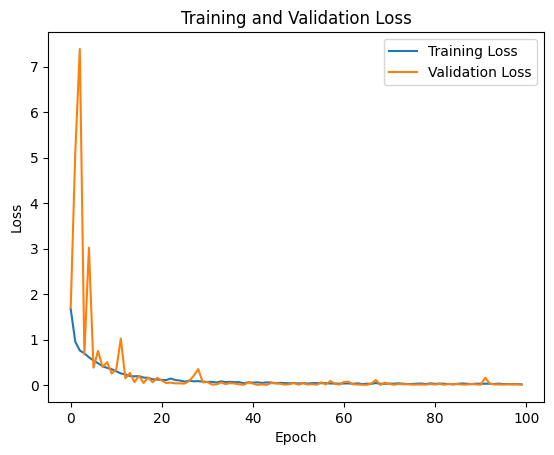

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
# Plot validation loss
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

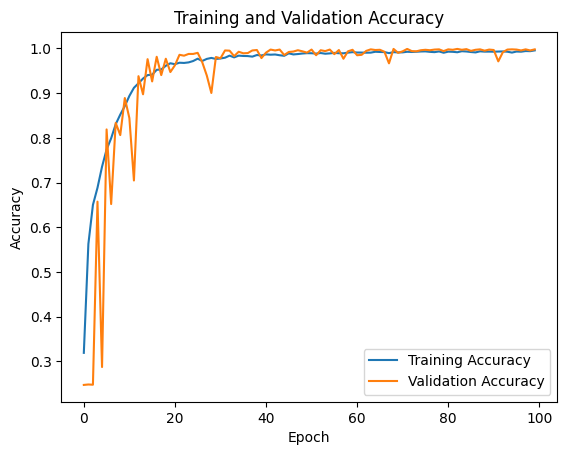

In [ ]:
# Plot training accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
# Plot validation accuracy
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

**PREDICTION ON THE VALIDATION DATA**

In [ ]:
pred_val = model.predict(val_data)

64/64 [==============================] - 1s 6ms/step


<Axes: >

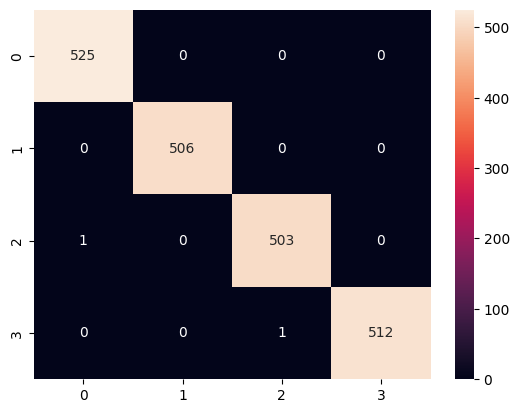

In [ ]:
predict_val = np.argmax(pred_val, axis=1)
true_val = np.argmax(val_labels, axis=1)
cm = confusion_matrix(predict_val, true_val)
sns.heatmap(cm, annot=True, fmt='d')

In [ ]:
val_report = classification_report(true_val, predict_val)
print(val_report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       526
           1       1.00      1.00      1.00       506
           2       1.00      1.00      1.00       504
           3       1.00      1.00      1.00       512

    accuracy                           1.00      2048
   macro avg       1.00      1.00      1.00      2048
weighted avg       1.00      1.00      1.00      2048



**PREDICTION ON THE TEST DATA**

In [ ]:
test_datagen = ImageDataGenerator(
    rescale=1./255
    #validation_split=0.2
)

batch_size = 1300

# Create a flow generator for training data
test_generator = test_datagen.flow_from_directory(
    test_data_dir,             # Path to the training data directory
    target_size=(176, 176), # Target size of the images (height, width)
    batch_size=batch_size,  # Size of the batches
    class_mode='categorical' # Type of labels (binary or categorical)
    #subset = 'training'
)

Found 1279 images belonging to 4 classes.


In [ ]:
test_data, test_labels = test_generator.next()

In [ ]:
print(test_data.shape, test_labels.shape)

(1279, 176, 176, 3) (1279, 4)


In [ ]:
test_scores = model.evaluate(test_data, test_labels)

40/40 [==============================] - 1s 7ms/step - loss: 1.0711 - accuracy: 0.8100


In [ ]:
pred_test = model.predict(test_data)

40/40 [==============================] - 0s 6ms/step


<Axes: >

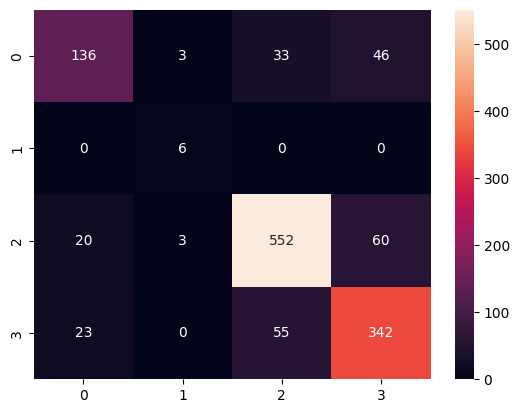

In [ ]:
predict_test = np.argmax(pred_test, axis=1)
true_test = np.argmax(test_labels, axis=1)
cm = confusion_matrix(predict_test, true_test)
sns.heatmap(cm, annot=True, fmt='d')

In [ ]:
test_report = classification_report(true_test, predict_test)
print(test_report)

              precision    recall  f1-score   support

           0       0.62      0.76      0.69       179
           1       1.00      0.50      0.67        12
           2       0.87      0.86      0.87       640
           3       0.81      0.76      0.79       448

    accuracy                           0.81      1279
   macro avg       0.83      0.72      0.75      1279
weighted avg       0.82      0.81      0.81      1279

